✅ AUC (Risk Score 기반): 0.652

📊 로지스틱 회귀 계수:
  Variable  Coefficient
0      age     0.051696
1       TC    -0.006901
2      BMI     0.056168
3      LDL    -0.010231
4      DBP     0.005272

✅ 리스크 스코어 계산 완료 → 저장됨: CACS_risk_score_output.xlsx


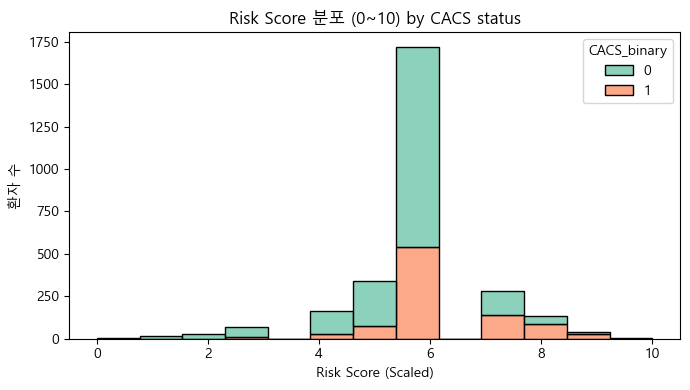

📌 최적 threshold (logit 기준): -0.726


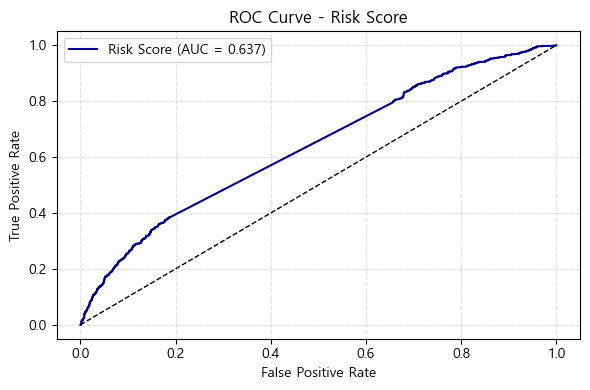

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 1. 데이터 불러오기
df = pd.read_excel("CACS_model_ready_imputed.xlsx")
df["CACS_binary"] = (df["CACS"] >= 100).astype(int)

# 2. SHAP 중요도 기반 변수 선택 (예: 상위 5개 변수)
selected_features = ["age", "TC", "BMI", "LDL", "DBP"]
X = df[selected_features]
y = df["CACS_binary"]

# 3. 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 로지스틱 회귀 모델 학습
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 5. 성능 평가
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("✅ AUC (Risk Score 기반):", round(auc, 3))

# 6. 회귀 계수 확인 (스코어 변환 기반)
coef_table = pd.DataFrame({
    "Variable": selected_features,
    "Coefficient": model.coef_[0]
})
print("\n📊 로지스틱 회귀 계수:")
print(coef_table)

# 7. 위험 점수 계산 함수 예시
def calculate_risk_score(row, coef, intercept=0):
    score = intercept
    for var, w in zip(selected_features, coef):
        score += row[var] * w
    return score

# 스코어 계산 및 저장
df["risk_score"] = df.apply(lambda row: calculate_risk_score(row, model.coef_[0], model.intercept_[0]), axis=1)
df.to_excel("CACS_risk_score_output.xlsx", index=False)
print("\n✅ 리스크 스코어 계산 완료 → 저장됨: CACS_risk_score_output.xlsx")

# 점수화: 0~10 사이의 risk score (정규화 + 정수화)
df["risk_score_scaled"] = ((df["risk_score"] - df["risk_score"].min()) / 
                           (df["risk_score"].max() - df["risk_score"].min()) * 10).round(0).astype(int)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.histplot(data=df, x="risk_score_scaled", hue="CACS_binary", multiple="stack", palette="Set2")
plt.title("Risk Score 분포 (0~10) by CACS status")
plt.xlabel("Risk Score (Scaled)")
plt.ylabel("환자 수")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(df["CACS_binary"], df["risk_score"])
youden_index = tpr - fpr
best_idx = youden_index.argmax()
optimal_threshold = thresholds[best_idx]
print("📌 최적 threshold (logit 기준):", round(optimal_threshold, 3))

df["predicted_high_risk"] = (df["risk_score"] >= optimal_threshold).astype(int)

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"  # Windows 한글폰트

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. 데이터 불러오기
df = pd.read_excel("CACS_risk_score_output.xlsx")

# 2. 정답 레이블과 예측 점수 설정
y_true = df["CACS_binary"]
y_score = df["risk_score"]  # 또는 df["risk_score_scaled"]

# 3. ROC Curve 계산
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)

# 4. 시각화
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Risk Score (AUC = {auc:.3f})", color="darkblue")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Risk Score")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

